In [1]:
pwd

'/Users/in-divye.singh/Documents/Projects/MIC_predictor/notebooks/classifier'

In [2]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [4]:
from notebooks.utils import *

In [5]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [8]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence', 'MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [22]:
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= 5 else 0)

### AA Frequency

In [46]:
aa_freq = reduce_by_kmer_frequency(df).sort_index(axis=1)

In [47]:
tsne = TSNE()

In [50]:
X = tsne.fit_transform(aa_freq)

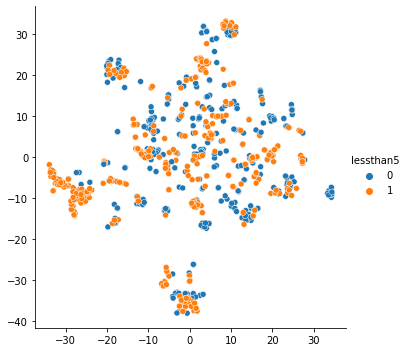

In [51]:
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])

### Dipeptide frequence

In [52]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [78]:
tsne = TSNE()

In [79]:
X = tsne.fit_transform(dipep_freq)

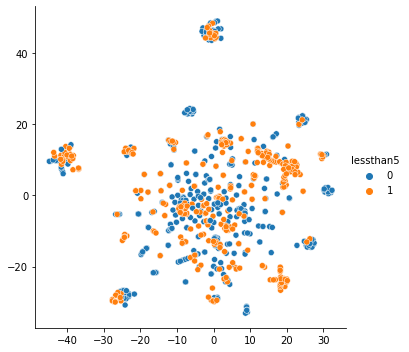

In [80]:
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])

### AA freq + dipeptide freq

In [57]:
aa_dipep_freq = pd.concat([aa_freq, dipep_freq], axis=1)

In [81]:
tsne = TSNE()

In [82]:
X = tsne.fit_transform(aa_dipep_freq)

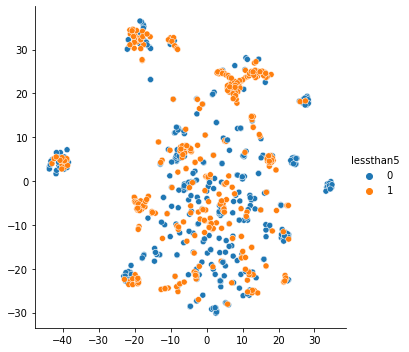

In [83]:
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])

In [84]:
pca = PCA()

In [85]:
avg_vec_pca = pca.fit_transform(aa_dipep_freq)

In [86]:
exp_var_cumsum = np.cumsum(pca.explained_variance_ratio_)

In [87]:
exp_var_cumsum

array([0.10122813, 0.17850668, 0.24504615, 0.30815361, 0.36392468,
       0.41335494, 0.45415499, 0.48944288, 0.52237916, 0.5488177 ,
       0.57290162, 0.59380577, 0.61198558, 0.62890668, 0.64370594,
       0.6578521 , 0.67125177, 0.68400579, 0.69506119, 0.70577376,
       0.71434111, 0.72266681, 0.73048438, 0.73774675, 0.74490488,
       0.75116301, 0.75696613, 0.76273546, 0.76830665, 0.77350512,
       0.77846179, 0.783175  , 0.78774402, 0.79203578, 0.79621609,
       0.80021683, 0.80417307, 0.80797495, 0.8117569 , 0.81541503,
       0.81894917, 0.82230591, 0.82557833, 0.82868933, 0.83174529,
       0.83470549, 0.83759455, 0.8403111 , 0.84298952, 0.84564867,
       0.84824806, 0.85080526, 0.85331037, 0.85571103, 0.85807984,
       0.86042988, 0.86268009, 0.86488257, 0.86705942, 0.86916939,
       0.87124455, 0.87327996, 0.87525007, 0.8772112 , 0.87908   ,
       0.88092684, 0.88275248, 0.88455367, 0.88631425, 0.88804125,
       0.88975353, 0.89142249, 0.89305433, 0.89467627, 0.89626

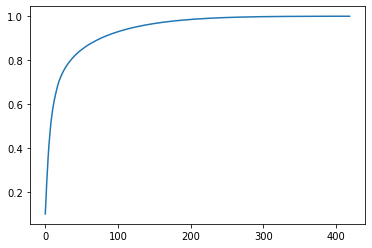

In [88]:
plt.plot(exp_var_cumsum)

In [89]:
from itertools import takewhile

In [96]:
threshold = 0.98
components = len(list(takewhile(lambda x: x<=threshold, exp_var_cumsum)))

In [100]:
tsne = TSNE()

In [101]:
X = tsne.fit_transform(avg_vec_pca[:,:components])

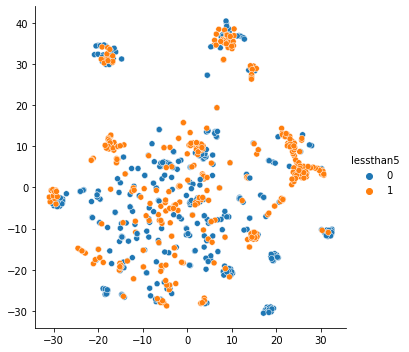

In [102]:
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])

### Avg ProtVec

In [11]:
uniprot_embedding = biovec.models.load_protvec("data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_vectors = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)

Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1154.49sequence/s]


In [13]:
tsne = TSNE()

In [14]:
X = tsne.fit_transform(avg_vectors)

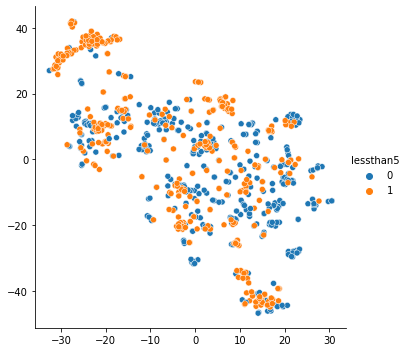

In [25]:
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])

In [37]:
pca = PCA()

In [38]:
avg_vec_pca = pca.fit_transform(avg_vectors)

In [39]:
exp_var_cumsum = np.cumsum(pca.explained_variance_ratio_)

In [40]:
exp_var_cumsum

array([0.24752527, 0.3616347 , 0.44199502, 0.51077366, 0.56111616,
       0.6014642 , 0.6262753 , 0.64790803, 0.6688007 , 0.6893322 ,
       0.70515704, 0.7202425 , 0.7335178 , 0.745116  , 0.75593185,
       0.7665049 , 0.77603287, 0.7849957 , 0.7933122 , 0.8015641 ,
       0.8090822 , 0.8162663 , 0.8231132 , 0.82947016, 0.8353058 ,
       0.84094507, 0.8465255 , 0.851692  , 0.8566614 , 0.8613204 ,
       0.86595964, 0.8704559 , 0.8747175 , 0.87880784, 0.882775  ,
       0.88669235, 0.89055634, 0.89418495, 0.8977806 , 0.9012423 ,
       0.90465724, 0.90791476, 0.9110719 , 0.91420615, 0.9172735 ,
       0.9202924 , 0.92315465, 0.92587656, 0.9285374 , 0.93110734,
       0.93363315, 0.9360696 , 0.938483  , 0.9408005 , 0.9430733 ,
       0.94522935, 0.9473614 , 0.9493971 , 0.9514219 , 0.9533907 ,
       0.95534277, 0.95720404, 0.9590531 , 0.96081716, 0.96255445,
       0.9642632 , 0.9659345 , 0.9675456 , 0.9691455 , 0.9706667 ,
       0.97214997, 0.9735868 , 0.97499055, 0.97634184, 0.97768

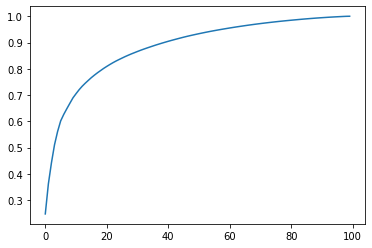

In [41]:
plt.plot(exp_var_cumsum)